# Textual-inversion fine-tuning for Stable Diffusion

Using just 3-5 images, you can teach new concepts to Stable Diffusion and personalize the model to your own set of images.

## Initial setup

In [2]:
!pip install  -U \
  torch==2.0.1 \
  accelerate==0.24.1 \
  transformers==4.35.2 \
  torchvision==0.15.2 \
  diffusers==0.23.1 \
  xformers==0.0.21 \
  bitsandbytes==0.41.1 \
  ftfy \
  tensorboard \
  Jinja2 \
  ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for ipywidgets from https://files.pythonhosted.org/packages/4a/0e/57ed498fafbc60419a9332d872e929879ceba2d73cb11d284d7112472b3e/ipywidgets-8.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for comm>=0.1.3 from https://files.pythonhosted.org/packages/7b/a6/5fd0242e974914b139451eea0a61ed9fd2e47157e33a67939043c50a94dd/comm-0.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for widgetsnbextension~=4.0.9 from https://files.pythonhosted.org/packages/29/03/107d96077c4befed191f7ad1a12c7b52a8f9d2778a5836d59f9855c105f6/widgetsnbextension-4.0.9-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab-widgets~=3.0.9 from https://files.pythonhosted.org/packages/e8/05/0ebab152288693b5ec7b339aab857362947031143b282853b4c2dd4b5b40/jupyterlab_widgets-3.0.9-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 101.6 MB

In [3]:
# !pip install git+https://github.com/huggingface/diffusers

In [4]:
# !pip uninstall xformers -y

In [5]:
# !conda install -y xformers -c xformers

In [6]:
from accelerate.utils import write_basic_config

write_basic_config()

Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

In [7]:
import argparse
import logging
import math
import os
import random
import shutil
import warnings
from pathlib import Path

import numpy as np
import PIL
import safetensors
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed

from packaging import version
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
)
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version #, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

if version.parse(version.parse(PIL.__version__).base_version) >= version.parse("9.1.0"):
    PIL_INTERPOLATION = {
        "linear": PIL.Image.Resampling.BILINEAR,
        "bilinear": PIL.Image.Resampling.BILINEAR,
        "bicubic": PIL.Image.Resampling.BICUBIC,
        "lanczos": PIL.Image.Resampling.LANCZOS,
        "nearest": PIL.Image.Resampling.NEAREST,
    }
else:
    PIL_INTERPOLATION = {
        "linear": PIL.Image.LINEAR,
        "bilinear": PIL.Image.BILINEAR,
        "bicubic": PIL.Image.BICUBIC,
        "lanczos": PIL.Image.LANCZOS,
        "nearest": PIL.Image.NEAREST,
    }
# ------------------------------------------------------------------------------

logger = get_logger(__name__)

In [8]:
def log_validation(text_encoder, tokenizer, unet, vae, args, accelerator, weight_dtype, epoch):
    logger.info(
        f"Running validation... \n Generating {args.num_validation_images} images with prompt:"
        f" {args.validation_prompt}."
    )
    # create pipeline (note: unet and vae are loaded again in float32)
    pipeline = DiffusionPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        text_encoder=accelerator.unwrap_model(text_encoder),
        tokenizer=tokenizer,
        unet=unet,
        vae=vae,
        safety_checker=None,
        revision=args.revision,
        torch_dtype=weight_dtype,
    )
    pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)

    # run inference
    generator = None if args.seed is None else torch.Generator(device=accelerator.device).manual_seed(args.seed)
    images = []
    for _ in range(args.num_validation_images):
        with torch.autocast("cuda"):
            image = pipeline(args.validation_prompt, num_inference_steps=25, generator=generator).images[0]
        images.append(image)

    for tracker in accelerator.trackers:
        if tracker.name == "tensorboard":
            np_images = np.stack([np.asarray(img) for img in images])
            tracker.writer.add_images("validation", np_images, epoch, dataformats="NHWC")
        if tracker.name == "wandb":
            tracker.log(
                {
                    "validation": [
                        wandb.Image(image, caption=f"{i}: {args.validation_prompt}") for i, image in enumerate(images)
                    ]
                }
            )

    del pipeline
    torch.cuda.empty_cache()
    return images


def save_progress(text_encoder, placeholder_token_ids, accelerator, args, save_path, safe_serialization=True):
    logger.info("Saving embeddings")
    learned_embeds = (
        accelerator.unwrap_model(text_encoder)
        .get_input_embeddings()
        .weight[min(placeholder_token_ids) : max(placeholder_token_ids) + 1]
    )
    learned_embeds_dict = {args.placeholder_token: learned_embeds.detach().cpu()}

    if safe_serialization:
        safetensors.torch.save_file(learned_embeds_dict, save_path, metadata={"format": "pt"})
    else:
        torch.save(learned_embeds_dict, save_path)


In [9]:
parser = argparse.ArgumentParser()

parser.add_argument(
    "--save_steps",
    type=int,
    default=500,
    help="Save learned_embeds.bin every X updates steps.",
)
parser.add_argument(
    "--save_as_full_pipeline",
    action="store_true",
    help="Save the complete stable diffusion pipeline.",
)
parser.add_argument(
    "--num_vectors",
    type=int,
    default=1,
    help="How many textual inversion vectors shall be used to learn the concept.",
)
parser.add_argument(
    "--pretrained_model_name_or_path",
    type=str,
    default="runwayml/stable-diffusion-v1-5",
    help="Path to pretrained model or model identifier from huggingface.co/models.",
)
parser.add_argument(
    "--revision",
    type=str,
    default=None,
    required=False,
    help="Revision of pretrained model identifier from huggingface.co/models.",
)
parser.add_argument(
    "--tokenizer_name",
    type=str,
    default=None,
    help="Pretrained tokenizer name or path if not the same as model_name",
)
parser.add_argument(
    "--train_data_dir", 
    type=str, 
    default="images_molly/", 
    help="A folder containing the training data."
)
parser.add_argument(
    "--placeholder_token",
    type=str,
    default="M*",
    help="A token to use as a placeholder for the concept.",
)
parser.add_argument(
    "--initializer_token", 
    type=str, 
    default="dog", 
    required=False, 
    help="A token to use as initializer word."
)
parser.add_argument("--learnable_property", 
                    type=str, 
                    default="object", 
                    help="Choose between 'object' and 'style'")
parser.add_argument("--repeats", 
                    type=int, 
                    default=100, 
                    help="How many times to repeat the training data.")
parser.add_argument(
    "--output_dir",
    type=str,
    default="textual_inversion_model",
    help="The output directory where the model predictions and checkpoints will be written.",
)
parser.add_argument("--seed", 
                    type=int, 
                    default=None, 
                    help="A seed for reproducible training.")
parser.add_argument(
    "--resolution",
    type=int,
    default=512,
    help=(
        "The resolution for input images, all the images in the train/validation dataset will be resized to this"
        " resolution"
    ),
)
parser.add_argument(
    "--center_crop", action="store_true", help="Whether to center crop images before resizing to resolution."
)
parser.add_argument(
    "--train_batch_size", type=int, default=1, help="Batch size (per device) for the training dataloader."
)
parser.add_argument("--num_train_epochs", type=int, default=100)
parser.add_argument(
    "--max_train_steps",
    type=int,
    default=200,
    help="Total number of training steps to perform.  If provided, overrides num_train_epochs.",
)
parser.add_argument(
    "--gradient_accumulation_steps",
    type=int,
    default=4,
    help="Number of updates steps to accumulate before performing a backward/update pass.",
)
parser.add_argument(
    "--gradient_checkpointing",
    action="store_true",
    help="Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass.",
)
parser.add_argument(
    "--learning_rate",
    type=float,
    default=5e-4,
    help="Initial learning rate (after the potential warmup period) to use.",
)
parser.add_argument(
    "--scale_lr",
    action="store_true",
    default=False,
    help="Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size.",
)
parser.add_argument(
    "--lr_scheduler",
    type=str,
    default="constant",
    help=(
        'The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial",'
        ' "constant", "constant_with_warmup"]'
    ),
)
parser.add_argument(
    "--lr_warmup_steps", 
    type=int, 
    default=0, 
    help="Number of steps for the warmup in the lr scheduler."
)
parser.add_argument(
    "--lr_num_cycles",
    type=int,
    default=1,
    help="Number of hard resets of the lr in cosine_with_restarts scheduler.",
)
parser.add_argument(
    "--dataloader_num_workers",
    type=int,
    default=0,
    help=(
        "Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process."
    ),
)
parser.add_argument("--adam_beta1", type=float, default=0.9, help="The beta1 parameter for the Adam optimizer.")
parser.add_argument("--adam_beta2", type=float, default=0.999, help="The beta2 parameter for the Adam optimizer.")
parser.add_argument("--adam_weight_decay", type=float, default=1e-2, help="Weight decay to use.")
parser.add_argument("--adam_epsilon", type=float, default=1e-08, help="Epsilon value for the Adam optimizer")

parser.add_argument(
    "--logging_dir",
    type=str,
    default="logs",
    help=(
        "[TensorBoard](https://www.tensorflow.org/tensorboard) log directory. Will default to"
        " *output_dir/runs/**CURRENT_DATETIME_HOSTNAME***."
    ),
)
parser.add_argument(
    "--mixed_precision",
    type=str,
    default="no",
    choices=["no", "fp16", "bf16"],
    help=(
        "Whether to use mixed precision. Choose"
        "between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >= 1.10."
        "and an Nvidia Ampere GPU."
    ),
)
parser.add_argument(
    "--allow_tf32",
    action="store_true",
    help=(
        "Whether or not to allow TF32 on Ampere GPUs. Can be used to speed up training. For more information, see"
        " https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices"
    ),
)
parser.add_argument(
    "--report_to",
    type=str,
    default="tensorboard",
    help=(
        'The integration to report the results and logs to. Supported platforms are `"tensorboard"`'
        ' (default), `"wandb"` and `"comet_ml"`. Use `"all"` to report to all integrations.'
    ),
)
parser.add_argument(
    "--validation_prompt",
    type=str,
    default=None,
    help="A prompt that is used during validation to verify that the model is learning.",
)
parser.add_argument(
    "--num_validation_images",
    type=int,
    default=4,
    help="Number of images that should be generated during validation with `validation_prompt`.",
)
parser.add_argument(
    "--validation_steps",
    type=int,
    default=100,
    help=(
        "Run validation every X steps. Validation consists of running the prompt"
        " `args.validation_prompt` multiple times: `args.num_validation_images`"
        " and logging the images."
    ),
)
parser.add_argument(
    "--validation_epochs",
    type=int,
    default=None,
    help=(
        "Deprecated in favor of validation_steps. Run validation every X epochs. Validation consists of running the prompt"
        " `args.validation_prompt` multiple times: `args.num_validation_images`"
        " and logging the images."
    ),
)
parser.add_argument("--local_rank", type=int, default=-1, help="For distributed training: local_rank")
parser.add_argument(
    "--checkpointing_steps",
    type=int,
    default=500,
    help=(
        "Save a checkpoint of the training state every X updates. These checkpoints are only suitable for resuming"
        " training using `--resume_from_checkpoint`."
    ),
)
parser.add_argument(
    "--checkpoints_total_limit",
    type=int,
    default=None,
    help=("Max number of checkpoints to store."),
)
parser.add_argument(
    "--resume_from_checkpoint",
    type=str,
    default=None,
    help=(
        "Whether training should be resumed from a previous checkpoint. Use a path saved by"
        ' `--checkpointing_steps`, or `"latest"` to automatically select the last available checkpoint.'
    ),
)
parser.add_argument(
    "--enable_xformers_memory_efficient_attention", action="store_true", help="Whether or not to use xformers."
)
parser.add_argument(
    "--no_safe_serialization",
    action="store_true",
    help="If specified save the checkpoint not in `safetensors` format, but in original PyTorch format instead.",
)

args, _ = parser.parse_known_args()

env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
if env_local_rank != -1 and env_local_rank != args.local_rank:
    args.local_rank = env_local_rank

if args.train_data_dir is None:
    raise ValueError("You must specify a train data directory.")

print(args)

Namespace(save_steps=500, save_as_full_pipeline=False, num_vectors=1, pretrained_model_name_or_path='runwayml/stable-diffusion-v1-5', revision=None, tokenizer_name=None, train_data_dir='images_molly/', placeholder_token='M*', initializer_token='dog', learnable_property='object', repeats=100, output_dir='textual_inversion_model', seed=None, resolution=512, center_crop=False, train_batch_size=1, num_train_epochs=100, max_train_steps=200, gradient_accumulation_steps=4, gradient_checkpointing=False, learning_rate=0.0005, scale_lr=False, lr_scheduler='constant', lr_warmup_steps=0, lr_num_cycles=1, dataloader_num_workers=0, adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=0.01, adam_epsilon=1e-08, logging_dir='logs', mixed_precision='no', allow_tf32=False, report_to='tensorboard', validation_prompt=None, num_validation_images=4, validation_steps=100, validation_epochs=None, local_rank=-1, checkpointing_steps=500, checkpoints_total_limit=None, resume_from_checkpoint=None, enable_xformers_m

In [10]:
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]


class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):
        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL_INTERPOLATION["linear"],
            "bilinear": PIL_INTERPOLATION["bilinear"],
            "bicubic": PIL_INTERPOLATION["bicubic"],
            "lanczos": PIL_INTERPOLATION["lanczos"],
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            (
                h,
                w,
            ) = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

In [11]:
logging_dir = os.path.join(args.output_dir, args.logging_dir)
accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)
accelerator = Accelerator(
    gradient_accumulation_steps=args.gradient_accumulation_steps,
    mixed_precision=args.mixed_precision,
    log_with=args.report_to,
    project_config=accelerator_project_config,
)

# if args.report_to == "wandb":
#     if not is_wandb_available():
#         raise ImportError("Make sure to install wandb if you want to use it for logging during training.")

# Make one log on every process with the configuration for debugging.
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state, main_process_only=False)
if accelerator.is_local_main_process:
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()

# If passed along, set the training seed now.
if args.seed is not None:
    set_seed(args.seed)

# Handle the repository creation
if accelerator.is_main_process:
    if args.output_dir is not None:
        os.makedirs(args.output_dir, exist_ok=True)

# Load tokenizer
if args.tokenizer_name:
    tokenizer = CLIPTokenizer.from_pretrained(args.tokenizer_name)
elif args.pretrained_model_name_or_path:
    tokenizer = CLIPTokenizer.from_pretrained(args.pretrained_model_name_or_path, subfolder="tokenizer")

# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
text_encoder = CLIPTextModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision
)
vae = AutoencoderKL.from_pretrained(args.pretrained_model_name_or_path, subfolder="vae", revision=args.revision)
unet = UNet2DConditionModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision
)

# Add the placeholder token in tokenizer
placeholder_tokens = [args.placeholder_token]

if args.num_vectors < 1:
    raise ValueError(f"--num_vectors has to be larger or equal to 1, but is {args.num_vectors}")

# add dummy tokens for multi-vector
additional_tokens = []
for i in range(1, args.num_vectors):
    additional_tokens.append(f"{args.placeholder_token}_{i}")
placeholder_tokens += additional_tokens

num_added_tokens = tokenizer.add_tokens(placeholder_tokens)
if num_added_tokens != args.num_vectors:
    raise ValueError(
        f"The tokenizer already contains the token {args.placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

# Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(args.initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_ids = tokenizer.convert_tokens_to_ids(placeholder_tokens)

# Resize the token embeddings as we are adding new special tokens to the tokenizer
text_encoder.resize_token_embeddings(len(tokenizer))

# Initialise the newly added placeholder token with the embeddings of the initializer token
token_embeds = text_encoder.get_input_embeddings().weight.data
with torch.no_grad():
    for token_id in placeholder_token_ids:
        token_embeds[token_id] = token_embeds[initializer_token_id].clone()

# Freeze vae and unet
vae.requires_grad_(False)
unet.requires_grad_(False)
# Freeze all parameters except for the token embeddings in text encoder
text_encoder.text_model.encoder.requires_grad_(False)
text_encoder.text_model.final_layer_norm.requires_grad_(False)
text_encoder.text_model.embeddings.position_embedding.requires_grad_(False)

if args.gradient_checkpointing:
    # Keep unet in train mode if we are using gradient checkpointing to save memory.
    # The dropout cannot be != 0 so it doesn't matter if we are in eval or train mode.
    unet.train()
    text_encoder.gradient_checkpointing_enable()
    unet.enable_gradient_checkpointing()

if args.enable_xformers_memory_efficient_attention:
    if is_xformers_available():
        import xformers

        xformers_version = version.parse(xformers.__version__)
        if xformers_version == version.parse("0.0.16"):
            logger.warn(
                "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
            )
        unet.enable_xformers_memory_efficient_attention()
    else:
        raise ValueError("xformers is not available. Make sure it is installed correctly")

# Enable TF32 for faster training on Ampere GPUs,
# cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
if args.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True

if args.scale_lr:
    args.learning_rate = (
        args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
    )

# Initialize the optimizer
optimizer = torch.optim.AdamW(
    text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

# Dataset and DataLoaders creation:
train_dataset = TextualInversionDataset(
    data_root=args.train_data_dir,
    tokenizer=tokenizer,
    size=args.resolution,
    placeholder_token=(" ".join(tokenizer.convert_ids_to_tokens(placeholder_token_ids))),
    repeats=args.repeats,
    learnable_property=args.learnable_property,
    center_crop=args.center_crop,
    set="train",
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.train_batch_size, shuffle=True, num_workers=args.dataloader_num_workers
)
if args.validation_epochs is not None:
    warnings.warn(
        f"FutureWarning: You are doing logging with validation_epochs={args.validation_epochs}."
        " Deprecated validation_epochs in favor of `validation_steps`"
        f"Setting `args.validation_steps` to {args.validation_epochs * len(train_dataset)}",
        FutureWarning,
        stacklevel=2,
    )
    args.validation_steps = args.validation_epochs * len(train_dataset)

# Scheduler and math around the number of training steps.
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if args.max_train_steps is None:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    overrode_max_train_steps = True

lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps * accelerator.num_processes,
    num_training_steps=args.max_train_steps * accelerator.num_processes,
    num_cycles=args.lr_num_cycles,
)

# Prepare everything with our `accelerator`.
text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    text_encoder, optimizer, train_dataloader, lr_scheduler
)

# For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

# Move vae and unet to device and cast to weight_dtype
unet.to(accelerator.device, dtype=weight_dtype)
vae.to(accelerator.device, dtype=weight_dtype)

# We need to recalculate our total training steps as the size of the training dataloader may have changed.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if overrode_max_train_steps:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
# Afterwards we recalculate our number of training epochs
args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

# We need to initialize the trackers we use, and also store our configuration.
# The trackers initializes automatically on the main process.
if accelerator.is_main_process:
    accelerator.init_trackers("textual_inversion", config=vars(args))

# Train!
total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num Epochs = {args.num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {args.max_train_steps}")
global_step = 0
first_epoch = 0

# Potentially load in the weights and states from a previous save
if args.resume_from_checkpoint:
    if args.resume_from_checkpoint != "latest":
        path = os.path.basename(args.resume_from_checkpoint)
    else:
        # Get the most recent checkpoint
        dirs = os.listdir(args.output_dir)
        dirs = [d for d in dirs if d.startswith("checkpoint")]
        dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
        path = dirs[-1] if len(dirs) > 0 else None

    if path is None:
        accelerator.print(
            f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
        )
        args.resume_from_checkpoint = None
    else:
        accelerator.print(f"Resuming from checkpoint {path}")
        accelerator.load_state(os.path.join(args.output_dir, path))
        global_step = int(path.split("-")[1])

        resume_global_step = global_step * args.gradient_accumulation_steps
        first_epoch = global_step // num_update_steps_per_epoch
        resume_step = resume_global_step % (num_update_steps_per_epoch * args.gradient_accumulation_steps)

# Only show the progress bar once on each machine.
progress_bar = tqdm(range(global_step, args.max_train_steps), disable=not accelerator.is_local_main_process)
progress_bar.set_description("Steps")

# keep original embeddings as reference
orig_embeds_params = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight.data.clone()

for epoch in range(first_epoch, args.num_train_epochs):
    text_encoder.train()
    for step, batch in enumerate(train_dataloader):
        # Skip steps until we reach the resumed step
        if args.resume_from_checkpoint and epoch == first_epoch and step < resume_step:
            if step % args.gradient_accumulation_steps == 0:
                progress_bar.update(1)
            continue

        with accelerator.accumulate(text_encoder):
            # Convert images to latent space
            latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
            latents = latents * vae.config.scaling_factor

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning
            encoder_hidden_states = text_encoder(batch["input_ids"])[0].to(dtype=weight_dtype)

            # Predict the noise residual
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            # Get the target for loss depending on the prediction type
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

            accelerator.backward(loss)

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            # Let's make sure we don't update any embedding weights besides the newly added token
            index_no_updates = torch.ones((len(tokenizer),), dtype=torch.bool)
            index_no_updates[min(placeholder_token_ids) : max(placeholder_token_ids) + 1] = False

            with torch.no_grad():
                accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[
                    index_no_updates
                ] = orig_embeds_params[index_no_updates]

        # Checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            images = []
            progress_bar.update(1)
            global_step += 1
            if global_step % args.save_steps == 0:
                weight_name = (
                    f"learned_embeds-steps-{global_step}.bin"
                    if args.no_safe_serialization
                    else f"learned_embeds-steps-{global_step}.safetensors"
                )
                save_path = os.path.join(args.output_dir, weight_name)
                save_progress(
                    text_encoder,
                    placeholder_token_ids,
                    accelerator,
                    args,
                    save_path,
                    safe_serialization=not args.no_safe_serialization,
                )

            if accelerator.is_main_process:
                if global_step % args.checkpointing_steps == 0:
                    # _before_ saving state, check if this save would set us over the `checkpoints_total_limit`
                    if args.checkpoints_total_limit is not None:
                        checkpoints = os.listdir(args.output_dir)
                        checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                        checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                        # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
                        if len(checkpoints) >= args.checkpoints_total_limit:
                            num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
                            removing_checkpoints = checkpoints[0:num_to_remove]

                            logger.info(
                                f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                            )
                            logger.info(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                            for removing_checkpoint in removing_checkpoints:
                                removing_checkpoint = os.path.join(args.output_dir, removing_checkpoint)
                                shutil.rmtree(removing_checkpoint)

                    save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)
                    logger.info(f"Saved state to {save_path}")

                if args.validation_prompt is not None and global_step % args.validation_steps == 0:
                    images = log_validation(
                        text_encoder, tokenizer, unet, vae, args, accelerator, weight_dtype, epoch
                    )

        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)

        if global_step >= args.max_train_steps:
            break
            

# Create the pipeline using the trained modules and save it.
accelerator.wait_for_everyone()

save_full_model = args.save_as_full_pipeline

if save_full_model:
    pipeline = StableDiffusionPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        text_encoder=accelerator.unwrap_model(text_encoder),
        vae=vae,
        unet=unet,
        tokenizer=tokenizer,
    )
    pipeline.save_pretrained(args.output_dir)
# Save the newly trained embeddings
weight_name = "learned_embeds.bin" if args.no_safe_serialization else "learned_embeds.safetensors"
save_path = os.path.join(args.output_dir, weight_name)
save_progress(
    text_encoder,
    placeholder_token_ids,
    accelerator,
    args,
    save_path,
    safe_serialization=not args.no_safe_serialization,
)

accelerator.end_training()

Detected kernel version 4.14.327, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
11/17/2023 21:20:10 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

{'timestep_spacing', 'dynamic_thresholding_ratio', 'thresholding', 'clip_sample_range', 'variance_type', 'sample_max_value', 'prediction_type'} was not found in config. Values will be initialized to default values.
{'force_upcast', 'scaling_factor'} was not found in config. Values will be initialized to default values.
{'transformer_layers_per_block', 'mid_block_only_cross_attention', 'mid_block_type', 'time_embedding_dim', 'timestep_post_act', 'conv_out_kernel', 'num_attention_heads', 'projection_class_embeddings_input_dim', 'attention_type', 'reverse_transformer_layers_per_block', 'conv_in_kernel', 'encoder_hid_dim', 'encoder_hid_di

  0%|          | 0/200 [00:00<?, ?it/s]

11/17/2023 21:26:31 - INFO - __main__ - Saving embeddings


## Perform Inference

Next, we can perform inference using our learned embeddings combined with a prompt that contains the learned token 'M*'

In [12]:
from diffusers import StableDiffusionPipeline
import torch

In [13]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")

{'requires_safety_checker'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of runwayml/stable-diffusion-v1-5.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of runwayml/stable-diffusion-v1-5.
{'force_upcast', 'scaling_factor'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of runwayml/stable-diffusion-v1-5.
{'transformer_layers_per_block', 'mid_block_only_cross_attention', 'mid_block_type', 'time_embedding_dim', 'timestep_post_act', 'conv_out_kernel', 'num_attention_heads', 'projection_class_embeddings_input_dim', 'attention_type', 'reverse_transformer_layers_per_block', 'conv_in_kernel', 'encoder_hid_dim', 'encoder_hid_dim_type', 'addition_embed_type', 'resnet_out_scale_factor', 'addition_embed_type_num_heads', 'use_linear_projection', 'cross_attention_norm', 'dropout', 'time_embedding_type',

In [14]:
pipe.load_textual_inversion("./textual_inversion_model", token="M*")

Loaded textual inversion embedding for M*.


In [15]:
prompt = "An oil painting of M*"

image = pipe(prompt, num_inference_steps=50).images[0]
image.save("output/molly-dog3.png")

  0%|          | 0/50 [00:00<?, ?it/s]

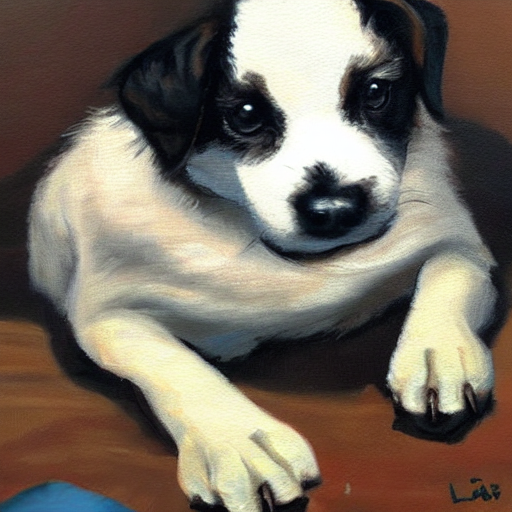

In [16]:
from IPython.display import Image
Image("./output/molly-dog3.png")

In [17]:
from diffusers import StableDiffusionPipeline
import torch

In [18]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")

{'requires_safety_checker'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of runwayml/stable-diffusion-v1-5.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of runwayml/stable-diffusion-v1-5.
{'force_upcast', 'scaling_factor'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of runwayml/stable-diffusion-v1-5.
{'transformer_layers_per_block', 'mid_block_only_cross_attention', 'mid_block_type', 'time_embedding_dim', 'timestep_post_act', 'conv_out_kernel', 'num_attention_heads', 'projection_class_embeddings_input_dim', 'attention_type', 'reverse_transformer_layers_per_block', 'conv_in_kernel', 'encoder_hid_dim', 'encoder_hid_dim_type', 'addition_embed_type', 'resnet_out_scale_factor', 'addition_embed_type_num_heads', 'use_linear_projection', 'cross_attention_norm', 'dropout', 'time_embedding_type',

In [19]:
pipe.load_textual_inversion("./textual_inversion_model", token="M*")

Loaded textual inversion embedding for M*.


In [20]:
prompt = "An oil painting of M*"

image = pipe(prompt, num_inference_steps=50).images[0]
image.save("output/molly-dog3.png")

  0%|          | 0/50 [00:00<?, ?it/s]

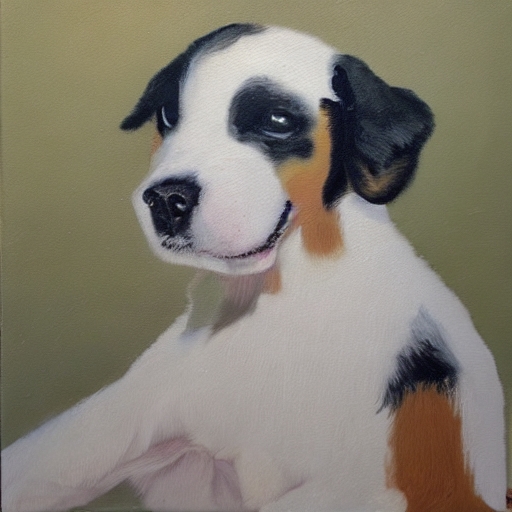

In [21]:
from IPython.display import Image
Image("./output/molly-dog3.png")